In [3]:
from pyfeti.src.utils import DomainCreator, dict2dfmap, create_selection_operator, DiskCreator
from pyfeti.src.feti_solver import SerialFETIsolver, SolverManager
from pyfeti.cases.case_generator import FETIcase_builder
from scipy import sparse
import amfe
import numpy as np
import matplotlib.pyplot as plt

# PYFETI version : github domaincreator 8f1e9152ae023e6aa9fda8aeb85dd7dd18eb890a

class DofManager():
    def __init__(self,element_df,node_df):
        self.element_df = element_df
        self.node_df = node_df
        self.tag = 'phys_group'
    
    def get_dof_from_node(self,node_id):
        node_df = self.node_df
        return list(node_df.iloc[node_id])
        
    def get_connectivity_from_elem_id(self,elem_id): 
        element_df = self.element_df
        return list(element_df['connectivity'].iloc[elem_id])
    
    def get_dof_list_from_elem_id(self,elem_id):
        return list(map(self.get_dof_from_node,self.get_connectivity_from_elem_id(elem_id)))
    
    def get_elements_from_group_id(self,group_id):
        element_df = self.element_df
        tag = self.tag
        return list(element_df.loc[element_df[tag] == group_id].index)
    
    def get_dof_list_from_group_id(self,group_id): 
        return np.sort(np.array(list(map(self.get_dof_list_from_elem_id,self.get_elements_from_group_id(group_id)))).flatten())
    
    def get_node_list_from_group_id(self,group_id):
        node_list = []
        for elem_id in self.get_elements_from_group_id(group_id): 
            node_list.extend(self.get_connectivity_from_elem_id(elem_id))
        return np.sort(node_list)

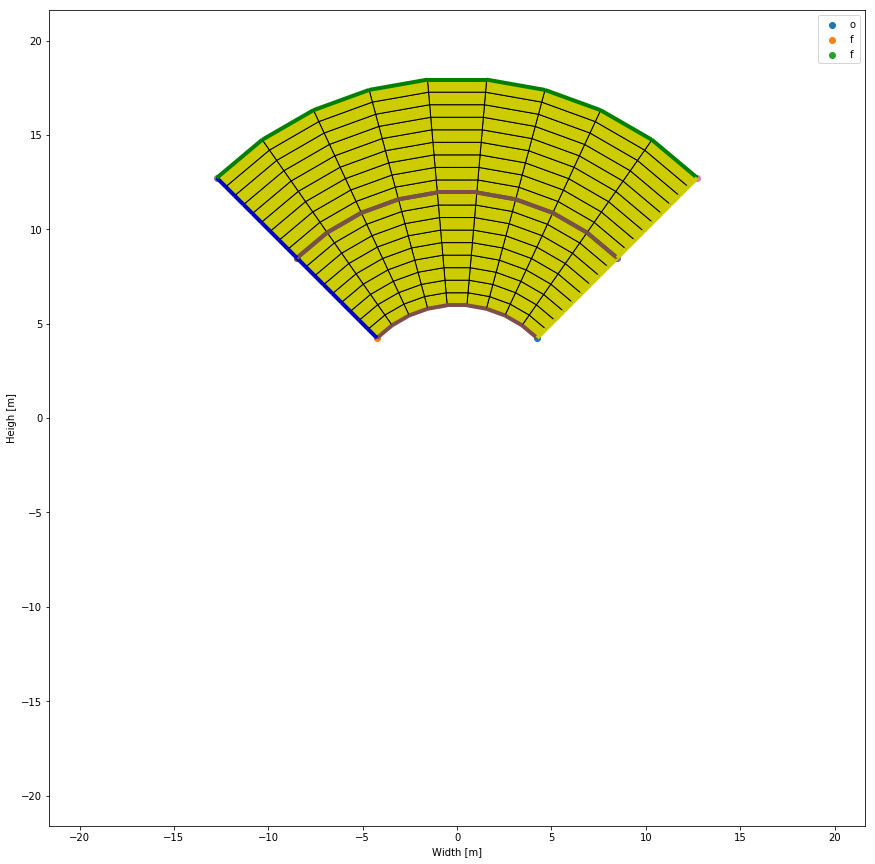

In [4]:
r_in_1 = 6
r_out_1 = 12
r_in_2 = r_out_1
r_out_2 = 18
angle=90
theta_0=(90-angle/2)
angle_divisions = 10
radial_divisions = 10
dobj1 = DiskCreator(r_in=r_in_1,r_out=r_out_1, sector_angle=angle, theta_0=theta_0,angle_divisions=angle_divisions,radial_divisions=radial_divisions)
dobj2 = DiskCreator(r_in=r_in_2,r_out=r_out_2, sector_angle=angle, theta_0=theta_0,angle_divisions=angle_divisions,radial_divisions=radial_divisions)

mesh_file1 = 'mesh_1.msh'
mesh_file2 = 'mesh_2.msh'
dobj1.save_gmsh_file(mesh_file1)
dobj2.save_gmsh_file(mesh_file2)

m1 = amfe.Mesh()
m1.import_msh(mesh_file1)

m2 = amfe.Mesh()
m2.import_msh(mesh_file2)

fig, ax1 = plt.subplots(1,1,figsize=(15,15))
amfe.plot2Dmesh(m1,ax=ax1)
amfe.plot2Dmesh(m2,ax=ax1)
mult=1.2
ax1.set_xlim([-mult*r_out_2,mult*r_out_2])
ax1.set_ylim([-mult*r_out_2,mult*r_out_2])
ax1.set_aspect('equal')
ax1.set_xlabel('Width [m]')
ax1.set_ylabel('Heigh [m]')
plt.legend('off')